In [1289]:
from fastquant import get_stock_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestRegressor
from scipy.ndimage.filters import gaussian_filter

In [1290]:
sigma = 1
d = 5

In [1291]:
def data_prep(data):
    return data['close'].pct_change().iloc[1:].values

In [1327]:
training_data = get_stock_data('HD','2000-01-01','2021-01-01')
testing_data = get_stock_data('HD','2021-01-01','2021-05-11')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [1328]:
train_data = training_data['close'].values
train_obs = data_prep(training_data)
train_obs = gaussian_filter(train_obs, sigma=sigma)

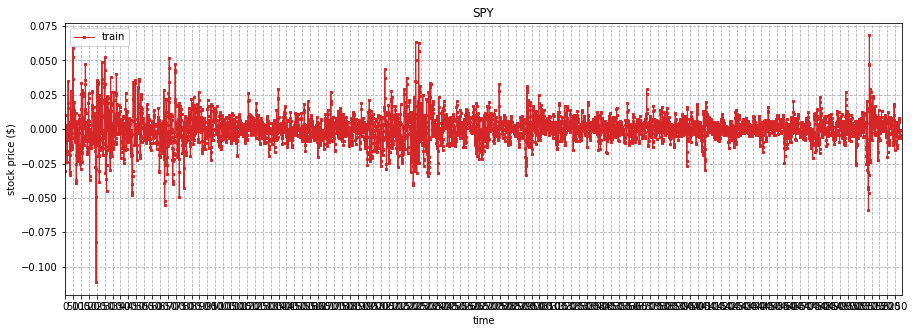

In [1329]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('SPY')
time = range(len(train_obs))
ax.plot(time,train_obs,color='tab:red',marker='s',markersize=2,linestyle='-',linewidth=1,label='train')
ax.set_xlabel('time')
ax.set_ylabel('stock price ($)')
ax.set_xticks(np.arange(0,len(train_obs)+10,50))
ax.set_xlim(0,len(train_obs)+10)
ax.xaxis.grid(True,ls='--')
ax.yaxis.grid(True,ls='--')
ax.legend()
plt.show()

In [1330]:
# build the x as the observation from (O_i,...,O_i+d)
# y is O_i+d
x_train, y_train = [],[]
for i in range(d, len(train_obs)):
    x_train.append(train_obs[i-d:i])
    y_train.append(train_obs[i])

x_train,y_train = np.array(x_train),np.array(y_train)
y_train = np.reshape(y_train, (*y_train.shape,1))

In [1331]:
x_train

array([[-0.03032228, -0.01584595, -0.00344295,  0.00998846,  0.00307875],
       [-0.01584595, -0.00344295,  0.00998846,  0.00307875, -0.0095516 ],
       [-0.00344295,  0.00998846,  0.00307875, -0.0095516 , -0.00552892],
       ...,
       [-0.00228415, -0.00154911, -0.00052319, -0.00086744, -0.00445736],
       [-0.00154911, -0.00052319, -0.00086744, -0.00445736, -0.0065742 ],
       [-0.00052319, -0.00086744, -0.00445736, -0.0065742 , -0.00407382]])

In [1332]:
regr = RandomForestRegressor(n_estimators=1000, max_depth=25, max_samples=150, random_state=0)

In [1333]:
regr.fit(x_train, y_train)

RandomForestRegressor(max_depth=25, max_samples=150, n_estimators=1000,
                      random_state=0)

In [1334]:
preds = regr.predict(x_train)

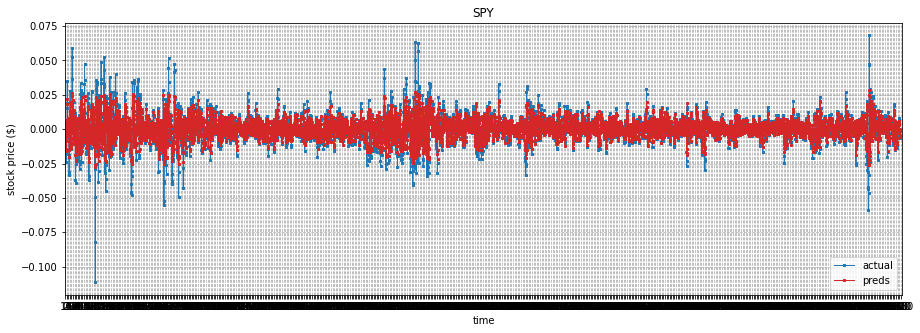

In [1335]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('SPY')
time = range(len(preds))
ax.plot(time,y_train,color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1,label='actual')
ax.plot(time,preds,color='tab:red',marker='s',markersize=2,linestyle='-',linewidth=1,label='preds')
ax.set_xlabel('time')
ax.set_ylabel('stock price ($)')
ax.set_xticks(np.arange(0,len(preds)+10,10))
ax.set_xlim(0,len(preds)+10)
ax.xaxis.grid(True,ls='--')
ax.yaxis.grid(True,ls='--')
ax.legend()
plt.show()

In [1336]:
test_data = testing_data['close'].values

last = training_data.iloc[-1].to_dict()
row = pd.DataFrame(last, index=[0])
row['dt'] = None
testing_data = testing_data.reset_index()
testing_data = pd.concat([row,testing_data], ignore_index=True)

test_obs = data_prep(testing_data)
test_labels = test_obs.copy()
print(len(test_obs))
print(len(test_labels))
test_obs = gaussian_filter(test_obs, sigma=sigma)

test_obs = np.concatenate((train_obs[-d:], test_obs), axis=0)

# build the x as the observation from (O_i,...,O_i+d)
# y is O_i+d
x_test, y_test = [],[]
index = 0
for i in range(d, len(test_obs)):
    x_test.append(test_obs[i-d:i])
    y_test.append(test_labels[index])
    index += 1

x_test,y_test = np.array(x_test),np.array(y_test)
y_test = np.reshape(y_test, (*y_test.shape,1))

88
88


In [1337]:
print(len(test_obs))

93


In [1338]:
print(len(test_data))

88


In [1339]:
preds = regr.predict(x_test)

In [1340]:
len(preds)

88

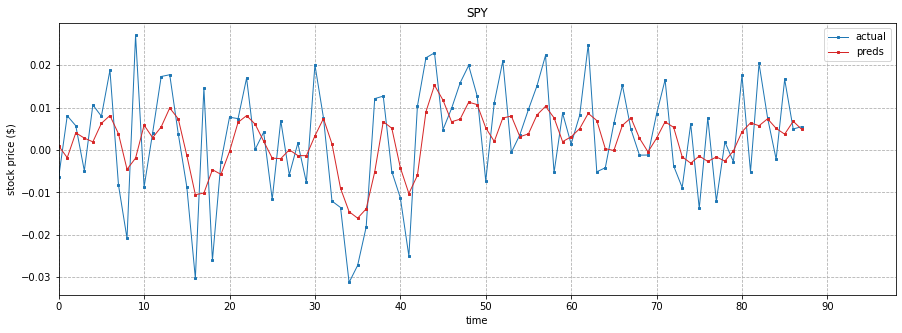

In [1341]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('SPY')
time = range(len(preds))
ax.plot(time,y_test,color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1,label='actual')
ax.plot(time,preds,color='tab:red',marker='s',markersize=2,linestyle='-',linewidth=1,label='preds')
ax.set_xlabel('time')
ax.set_ylabel('stock price ($)')
ax.set_xticks(np.arange(0,len(preds)+10,10))
ax.set_xlim(0,len(preds)+10)
ax.xaxis.grid(True,ls='--')
ax.yaxis.grid(True,ls='--')
ax.legend()
plt.show()

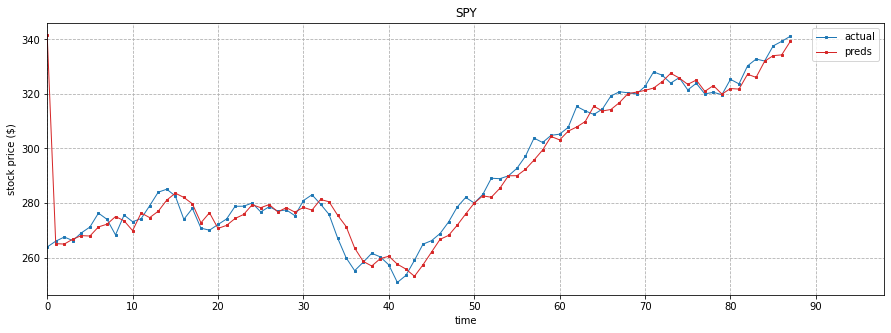

In [1342]:
pred_close = []
closes = testing_data['close'].values
for i,pred in enumerate(preds):
    pred_close.append(pred*closes[i-1]+closes[i-1])
truth = testing_data['close'].values[1:]
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('SPY')
time = range(len(preds))
ax.plot(time,truth,color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1,label='actual')
ax.plot(time,pred_close,color='tab:red',marker='s',markersize=2,linestyle='-',linewidth=1,label='preds')
ax.set_xlabel('time')
ax.set_ylabel('stock price ($)')
ax.set_xticks(np.arange(0,len(preds)+10,10))
ax.set_xlim(0,len(preds)+10)
ax.xaxis.grid(True,ls='--')
ax.yaxis.grid(True,ls='--')
ax.legend()
plt.show()

In [1343]:
from sklearn.ensemble import AdaBoostRegressor

In [1344]:
regr = AdaBoostRegressor(n_estimators=250, random_state=0)

In [1345]:
regr.fit(x_train, y_train)

AdaBoostRegressor(n_estimators=250, random_state=0)

In [1346]:
preds = regr.predict(x_train)

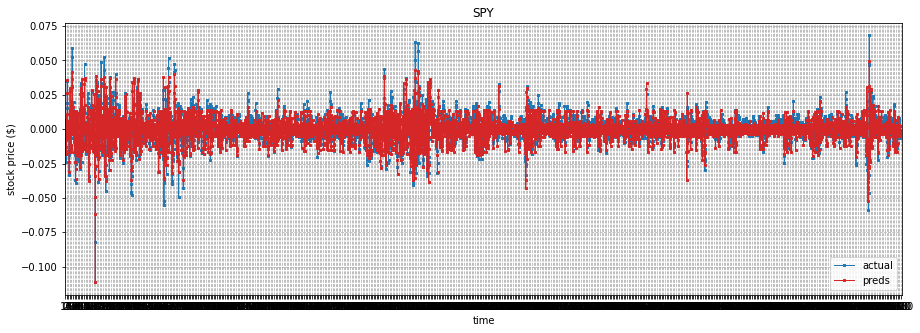

In [1347]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('SPY')
time = range(len(preds))
ax.plot(time,y_train,color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1,label='actual')
ax.plot(time,preds,color='tab:red',marker='s',markersize=2,linestyle='-',linewidth=1,label='preds')
ax.set_xlabel('time')
ax.set_ylabel('stock price ($)')
ax.set_xticks(np.arange(0,len(preds)+10,10))
ax.set_xlim(0,len(preds)+10)
ax.xaxis.grid(True,ls='--')
ax.yaxis.grid(True,ls='--')
ax.legend()
plt.show()

In [1348]:
preds = regr.predict(x_test)

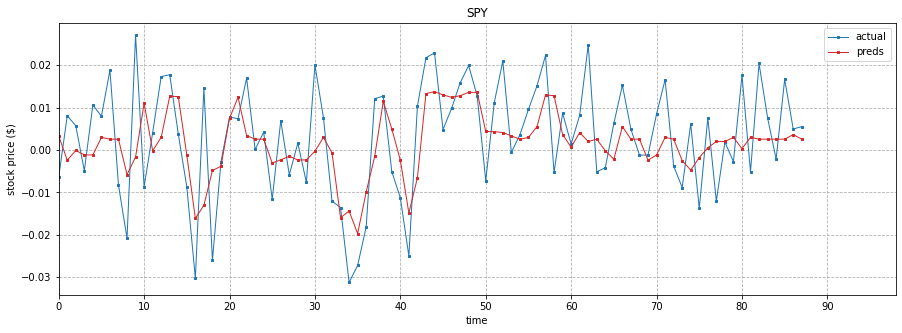

In [1349]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('SPY')
time = range(len(preds))
ax.plot(time,y_test,color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1,label='actual')
ax.plot(time,preds,color='tab:red',marker='s',markersize=2,linestyle='-',linewidth=1,label='preds')
ax.set_xlabel('time')
ax.set_ylabel('stock price ($)')
ax.set_xticks(np.arange(0,len(preds)+10,10))
ax.set_xlim(0,len(preds)+10)
ax.xaxis.grid(True,ls='--')
ax.yaxis.grid(True,ls='--')
ax.legend()
plt.show()

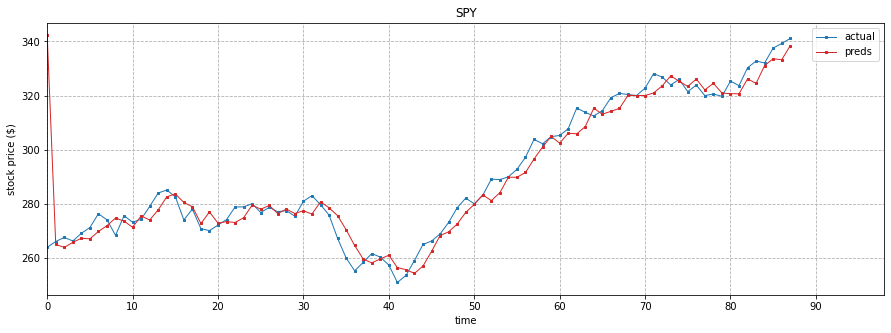

In [1350]:
pred_close = []
closes = testing_data['close'].values
for i,pred in enumerate(preds):
    pred_close.append(pred*closes[i-1]+closes[i-1])
truth = testing_data['close'].values[1:]
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('SPY')
time = range(len(preds))
ax.plot(time,truth,color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1,label='actual')
ax.plot(time,pred_close,color='tab:red',marker='s',markersize=2,linestyle='-',linewidth=1,label='preds')
ax.set_xlabel('time')
ax.set_ylabel('stock price ($)')
ax.set_xticks(np.arange(0,len(preds)+10,10))
ax.set_xlim(0,len(preds)+10)
ax.xaxis.grid(True,ls='--')
ax.yaxis.grid(True,ls='--')
ax.legend()
plt.show()

In [1351]:
from sklearn.ensemble import GradientBoostingRegressor

In [1352]:
regr = GradientBoostingRegressor(n_estimators=250, 
                                 loss='huber', 
                                 learning_rate=0.1,
                                 subsample=0.9,
                                 max_depth=10,
                                 random_state=0)

In [1353]:
regr.fit(x_train, y_train)

GradientBoostingRegressor(loss='huber', max_depth=10, n_estimators=250,
                          random_state=0, subsample=0.9)

In [1354]:
preds = regr.predict(x_train)

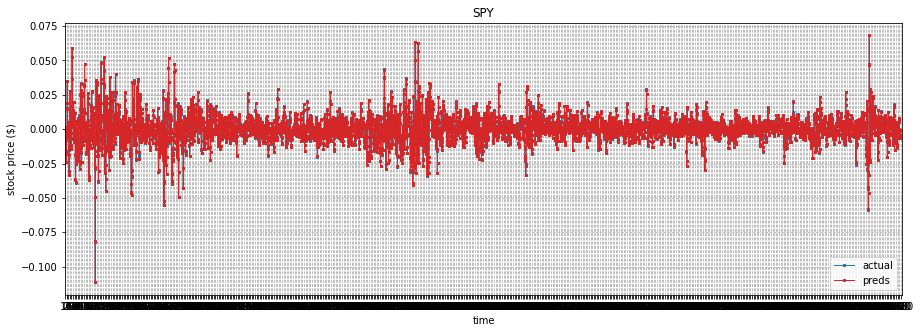

In [1355]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('SPY')
time = range(len(preds))
ax.plot(time,y_train,color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1,label='actual')
ax.plot(time,preds,color='tab:red',marker='s',markersize=2,linestyle='-',linewidth=1,label='preds')
ax.set_xlabel('time')
ax.set_ylabel('stock price ($)')
ax.set_xticks(np.arange(0,len(preds)+10,10))
ax.set_xlim(0,len(preds)+10)
ax.xaxis.grid(True,ls='--')
ax.yaxis.grid(True,ls='--')
ax.legend()
plt.show()

In [1356]:
preds = regr.predict(x_test)

In [1357]:
regr.score(x_test,y_test)

0.42131344737631515

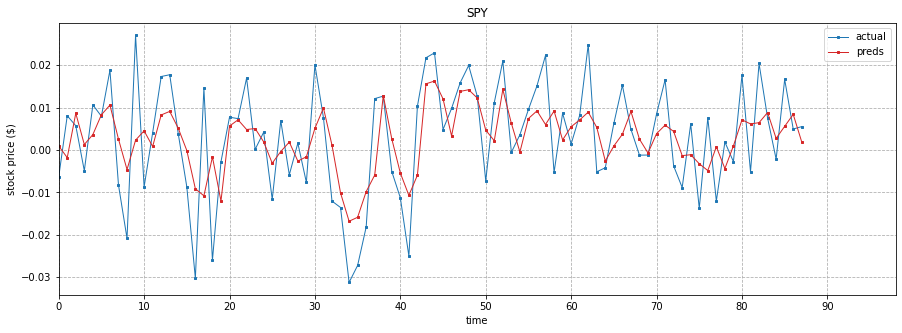

In [1358]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('SPY')
time = range(len(preds))
ax.plot(time,y_test,color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1,label='actual')
ax.plot(time,preds,color='tab:red',marker='s',markersize=2,linestyle='-',linewidth=1,label='preds')
ax.set_xlabel('time')
ax.set_ylabel('stock price ($)')
ax.set_xticks(np.arange(0,len(preds)+10,10))
ax.set_xlim(0,len(preds)+10)
ax.xaxis.grid(True,ls='--')
ax.yaxis.grid(True,ls='--')
ax.legend()
plt.show()

In [1359]:
len(testing_data)

89

In [1360]:
len(preds)

88

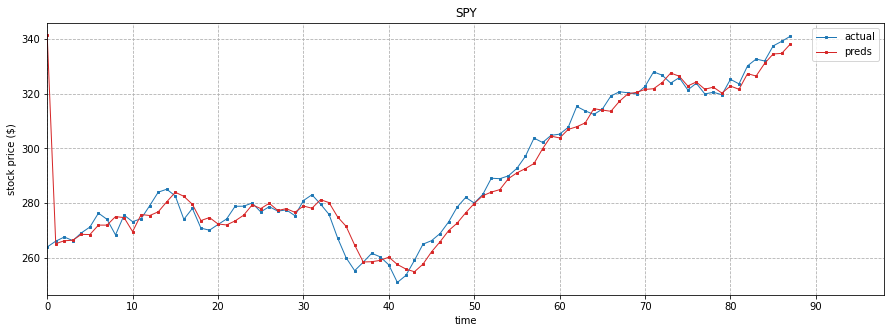

In [1361]:
pred_close = []
closes = testing_data['close'].values
opens = testing_data['open'].values[1:]
for i,pred in enumerate(preds):
    pred_close.append(pred*closes[i-1]+closes[i-1])
truth = testing_data['close'].values[1:]
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('SPY')
time = range(len(preds))
ax.plot(time,truth,color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1,label='actual')
#ax.plot(time,opens,color='tab:green',marker='s',markersize=2,linestyle='-',linewidth=1,label='opens')
ax.plot(time,pred_close,color='tab:red',marker='s',markersize=2,linestyle='-',linewidth=1,label='preds')
ax.set_xlabel('time')
ax.set_ylabel('stock price ($)')
ax.set_xticks(np.arange(0,len(preds)+10,10))
ax.set_xlim(0,len(preds)+10)
ax.xaxis.grid(True,ls='--')
ax.yaxis.grid(True,ls='--')
ax.legend()
plt.show()